In [22]:
%load_ext autoreload
%autoreload 2
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scripts.plot import plot_df, plot_forecast, plot_acf_pacf

df = pd.read_csv("./data/01_processed_output.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').asfreq('D')
df = df.temperature
df.tail()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


date
2022-03-27    20.9
2022-03-28    17.0
2022-03-29    18.7
2022-03-30    21.9
2022-03-31    23.5
Freq: D, Name: temperature, dtype: float64

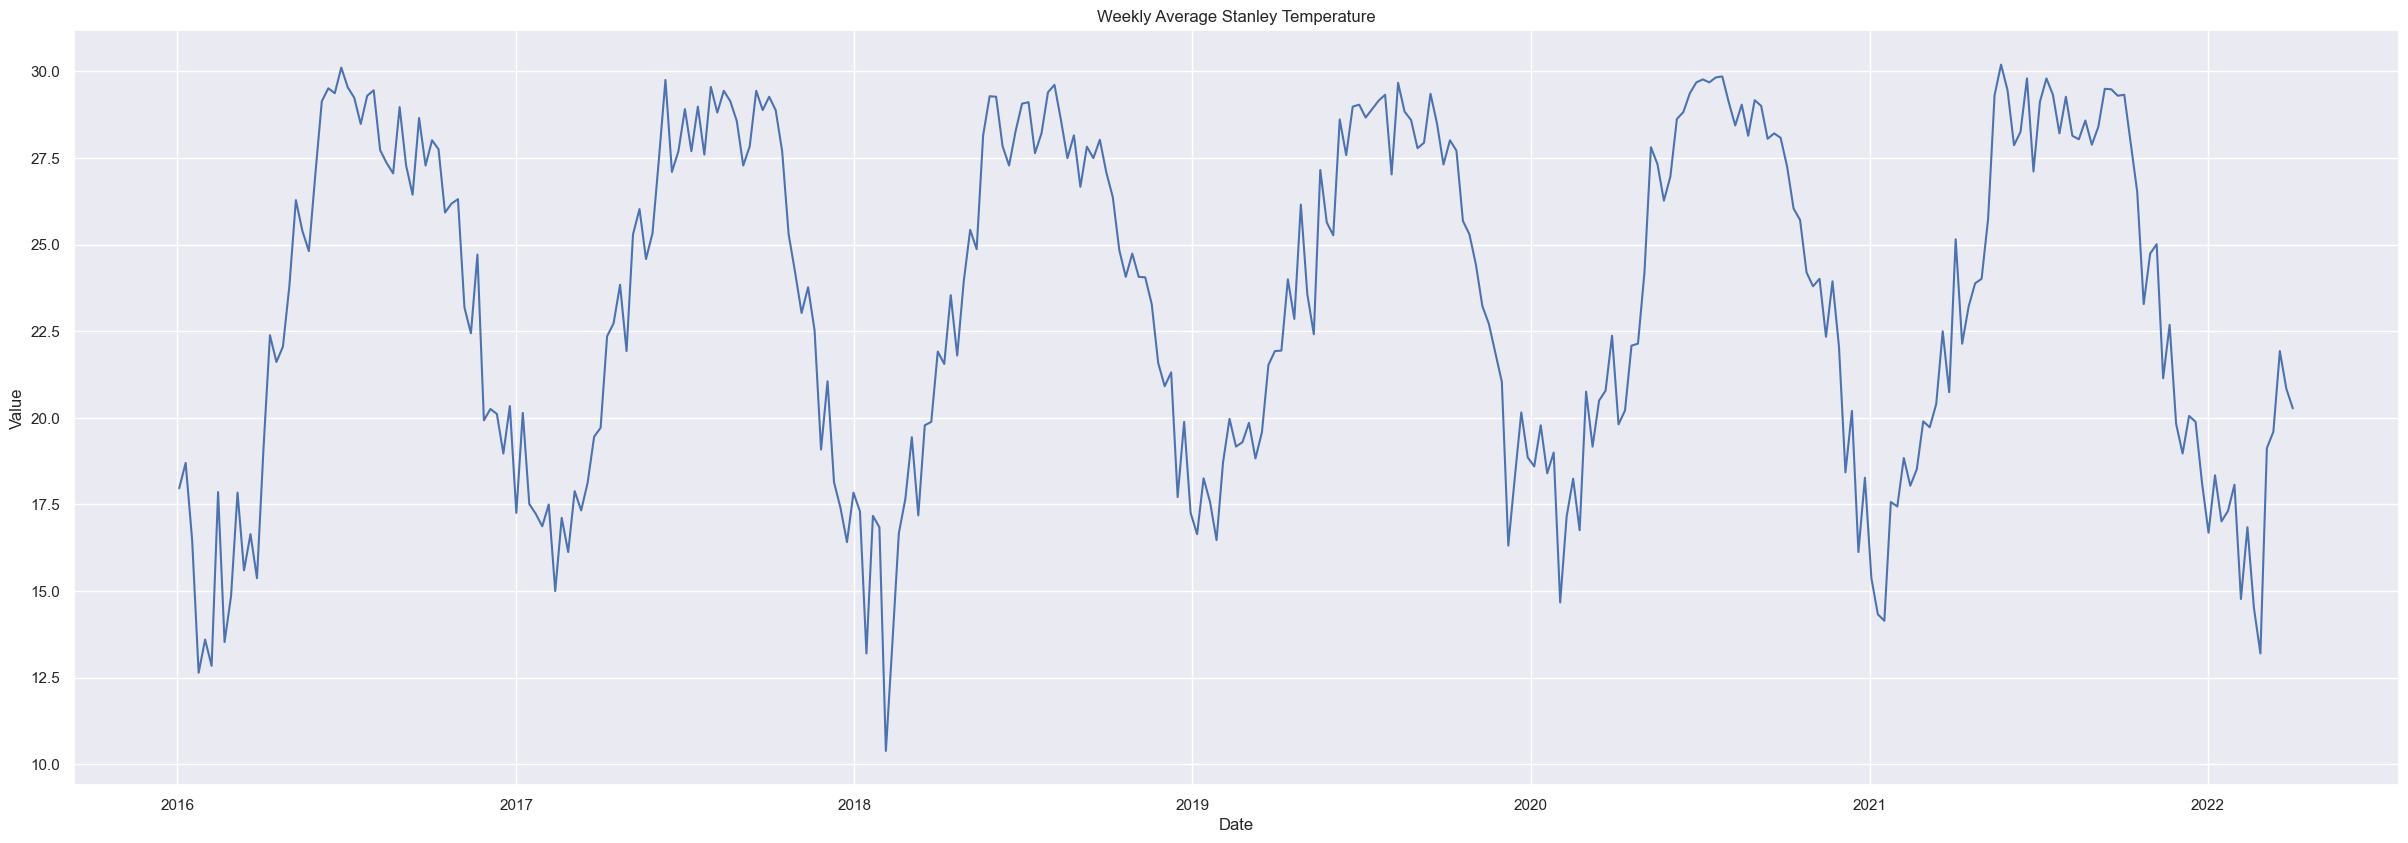

In [14]:
# Draw Plot
sns.set_theme()

start="2016-01-01"
range_df = df.loc[start:]
df_week = range_df.resample('W').mean()

# sns.lineplot(data=range_df,x=range_df.index,y=range_df.values)
plot_df(df_week, title='Weekly Average Stanley Temperature')  

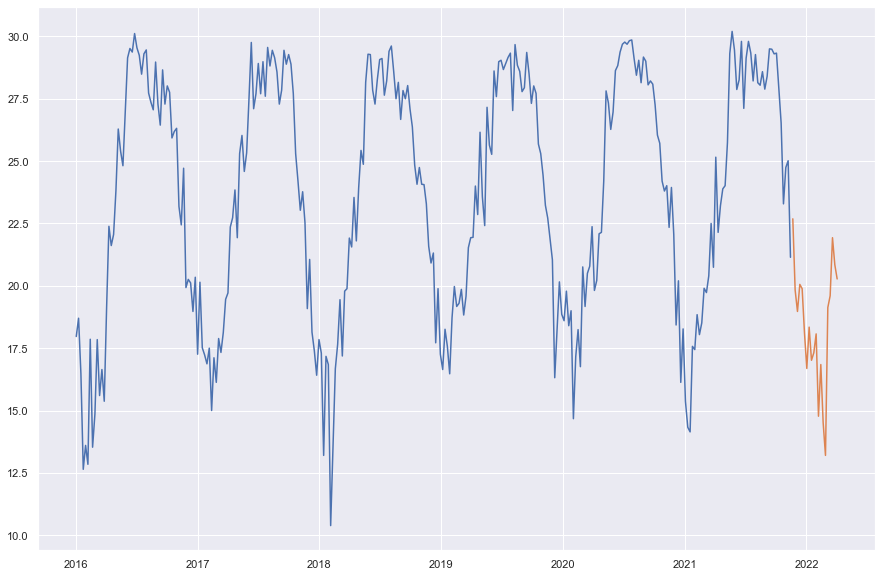

In [15]:
# Create Training and Test
test_size = 20  
train = df_week[:-test_size]
test = df_week[-test_size:]
# print(train[-5:])
# print(test)

plt.figure(figsize=(15, 10))
plt.plot(train[:])
plt.plot(test)


## Model fitting
Determine SARIMA model order using auto_arima, picking the best model in a stepwise manner with AIC as the minimization metric

In [35]:
stepwise_model = auto_arima(
    train, D=1, seasonal=True, m = 52, trace=True, suppress_warnings=True, stepwise=True
)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[52] intercept   : AIC=969.078, Time=49.66 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1074.004, Time=0.43 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=980.743, Time=7.60 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=7.76 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1074.537, Time=0.23 sec
 ARIMA(2,0,2)(0,1,1)[52] intercept   : AIC=inf, Time=31.69 sec
 ARIMA(2,0,2)(1,1,0)[52] intercept   : AIC=981.381, Time=24.03 sec
 ARIMA(2,0,2)(2,1,1)[52] intercept   : AIC=970.577, Time=87.09 sec
 ARIMA(2,0,2)(1,1,2)[52] intercept   : AIC=970.790, Time=96.49 sec
 ARIMA(2,0,2)(0,1,0)[52] intercept   : AIC=1049.671, Time=6.76 sec
 ARIMA(2,0,2)(0,1,2)[52] intercept   : AIC=968.794, Time=58.13 sec
 ARIMA(1,0,2)(0,1,2)[52] intercept   : AIC=967.885, Time=42.17 sec
 ARIMA(1,0,2)(0,1,1)[52] intercept   : AIC=inf, Time=19.14 sec
 ARIMA(1,0,2)(1,1,2)[52] intercept   : AIC=969.861, Time=74.00 sec
 ARIMA(1,0,2)(1,1,1)[52] intercep

In [44]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  307
Model:             SARIMAX(1, 0, 1)x(0, 1, [1, 2], 52)   Log Likelihood                -477.139
Date:                                 Sat, 23 Apr 2022   AIC                            966.278
Time:                                         18:00:17   BIC                            987.525
Sample:                                              0   HQIC                           974.824
                                                 - 307                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0582      0.036      1.610      0.107      -0.013       0.129
ar.L1          0.7043      0.129      5.445      0.000       0.451       0.958
ma.L1         -0.4903      0.156     -3.138      0.002      -0.796      -0.184
ma.S.L52      -0.7605      0.069    -10.979      0.000      -0.896      -0.625
ma.S.L104      0.1907      0.078      2.431      0.015       0.037       0.344
sigma2         2.1858      0.215     10.173      0.000       1.765       2.607
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.75   Prob(JB):                         0.28
Heteroskedasticity (H):               0.84   Skew:                            -0.18
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
acorr_ljungbox(stepwise_model.resid(), model_df=stepwise_model.df_model(), return_df=True)
stepwise_model.df_model()


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "


6

### Seasonal ARIMA

$$SARIMA(p,d,q)(P,D,Q)m$$

Although a seasonal ARIMA model seems to have only a few parameters, that backforecasting requires the estimation of one or two seasons' worth of implicit parameters to initialize it. Therefore, we should have at least 4 or 5 seasons of data to fit a seasonal ARIMA model.

### "Seasonal Exponential Smoothing"

Probably the most commonly used seasonal ARIMA model is the (0,1,1)x(0,1,1) model--i.e., an MA(1)xSMA(1) model with both a seasonal and a non-seasonal difference. This is essentially a "seasonal exponential smoothing" model.

In [48]:
auto_model = ARIMA(train, order=(1,0,1), seasonal_order=(0,1,2,52))
# model = ARIMA(train, order=(1,1,1))
auto_fitted = auto_model.fit()  
auto_fitted.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                           temperature   No. Observations:                  307
Model:             ARIMA(1, 0, 1)x(0, 1, [1, 2], 52)   Log Likelihood                -479.306
Date:                               Sat, 23 Apr 2022   AIC                            968.612
Time:                                       18:02:31   BIC                            986.318
Sample:                                   01-03-2016   HQIC                           975.734
                                        - 11-14-2021                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7770      0.095      8.140      0.000       0.590       0.964
ma.L1         -0.5501      0.123     -4.479      0.000      -0.791      -0.309
ma.S.L52      -0.7360      0.068    -10.775      0.000      -0.870      -0.602
ma.S.L104      0.1903      0.078      2.429      0.015       0.037       0.344
sigma2         2.2421      0.222     10.098      0.000       1.807       2.677
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.75
Prob(Q):                              0.88   Prob(JB):                         0.25
Heteroskedasticity (H):               0.84   Skew:                            -0.17
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

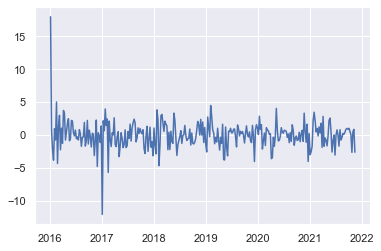

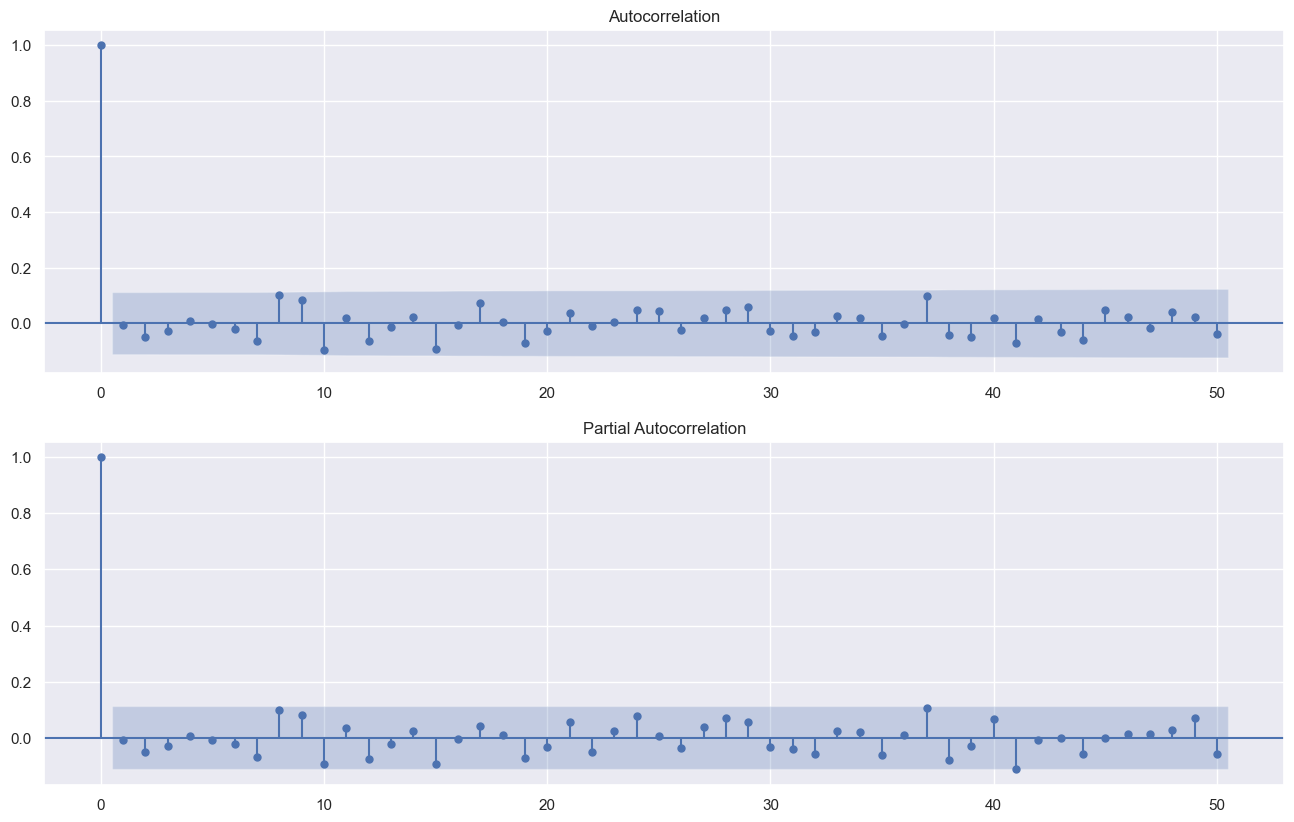

In [24]:
plt.plot(fitted2.resid)
plot_acf_pacf(fitted2.resid)

In [25]:
fitted2.params

ma.L1      -0.773757
ma.S.L52   -0.756073
sigma2      2.317552
dtype: float64

In [33]:
model = ARIMA(train, order=(0,0,0), seasonal_order=(4,1,0,52))
# model = ARIMA(train, order=(1,1,1))
fitted = model.fit()  
type(fitted)
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                  307
Model:             ARIMA(4, 1, 0, 52)   Log Likelihood                -493.982
Date:                Sat, 23 Apr 2022   AIC                            997.964
Time:                        16:56:32   BIC                           1015.670
Sample:                    01-03-2016   HQIC                          1005.086
                         - 11-14-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52      -0.6816      0.072     -9.507      0.000      -0.822      -0.541
ar.S.L104     -0.2056      0.113     -1.817      0.069      -0.427       0.016
ar.S.L156      0.0384      0.140      0.273      0.7

In [31]:
fitted.m
# fitted.params

{'seasonal_periods': 52,
 'measurement_error': False,
 'time_varying_regression': False,
 'simple_differencing': False,
 'enforce_stationarity': True,
 'enforce_invertibility': True,
 'hamilton_representation': False,
 'concentrate_scale': False,
 'trend_offset': 1,
 'order': (0, 0, 0),
 'seasonal_order': (4, 1, 0, 52),
 'k_diff': 0,
 'k_seasonal_diff': 1,
 'k_ar': 0,
 'k_ma': 0,
 'k_seasonal_ar': 208,
 'k_seasonal_ma': 0,
 'k_ar_params': 0,
 'k_ma_params': 0,
 'trend': 'n',
 'k_trend': 0,
 'k_exog': 0,
 'mle_regression': False,
 'state_regression': False}

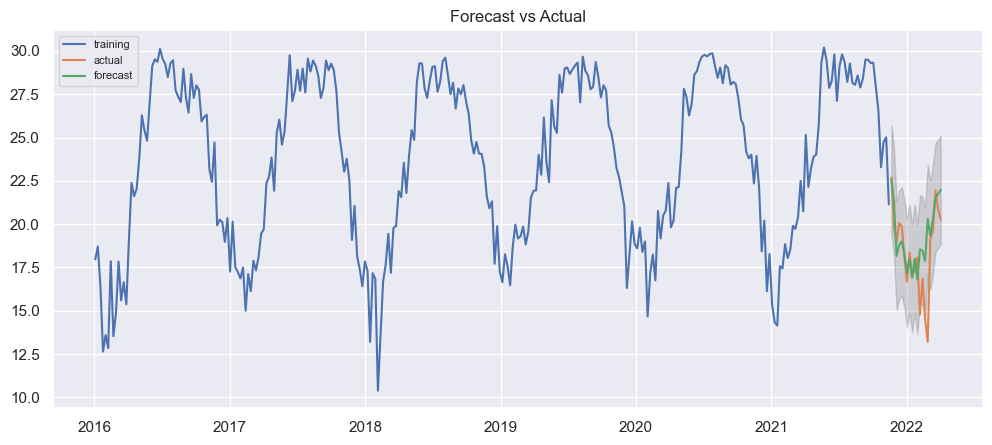

In [18]:
plot_forecast(fitted,test)

## Model Diagnostic

In [19]:
lags = np.array([5,10,15,50])
lb_test_res = acorr_ljungbox(fitted.resid, model_df=fitted.df_model, lags=lags, return_df=True)
lb_test_res.index.names = ['Lags']
lb_test_res

,lb_stat,lb_pvalue
Lags,,
5,1366.138447,NaN
10,2541.763748,0.0
15,3469.126139,0.0
50,4944.842642,0.0


In [20]:
# 
train == 

SyntaxError: invalid syntax (Temp/ipykernel_19808/394928340.py, line 2)